In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

#import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


In [ ]:
pip install tensorflow_addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 10.6 MB/s eta 0:00:00


In [ ]:
base_dir = "/content/drive/MyDrive/archive (12)/"
root_dir = "./"
test_dir = base_dir + "TEST/"
train_dir = base_dir + "TRAIN/"
work_dir = root_dir + "DataSet/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VMD', 'ND', 'MOD_D', 'MILD_D']


In [ ]:
WORK_DIR = './DataSet/'

CLASSES = [ 'ND',
            'VMD',
            'MILD_D',
            'MOD_D']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6407 images belonging to 4 classes.


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12832, 150, 150, 3) (12832, 4)


In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
inception_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

# CALLBACKS = rop_callback

custom_inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 40
history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/40
257/257 [==============================] - 42s 76ms/step - loss: 1.4009 - accuracy: 0.7407 - precision: 0.4655 - recall: 0.2498 - auc: 0.6683 - val_loss: 0.8276 - val_accuracy: 0.8264 - val_precision: 0.8138 - val_recall: 0.3960 - val_auc: 0.8715
Epoch 2/40
257/257 [==============================] - 13s 50ms/step - loss: 0.9781 - accuracy: 0.7962 - precision: 0.6784 - recall: 0.3511 - auc: 0.8195 - val_loss: 0.7372 - val_accuracy: 0.8333 - val_precision: 0.8441 - val_recall: 0.4087 - val_auc: 0.8953
Epoch 3/40
257/257 [==============================] - 12s 48ms/step - loss: 0.8530 - accuracy: 0.8197 - precision: 0.7570 - recall: 0.4105 - auc: 0.8633 - val_loss: 0.6700 - val_accuracy: 0.8514 - val_precision: 0.8612 - val_recall: 0.4837 - val_auc: 0.9164
Epoch 4/40
257/257 [==============================] - 13s 50ms/step - loss: 0.8016 - accuracy: 0.8267 - precision: 0.7625 - recall: 0.4456 - auc: 0.8808 - val_loss: 0.6389 - val_accuracy: 0.8567 - val_precision: 0.8328 - val_r

In [ ]:
custom_inception_model.save('/content/drive/MyDrive/history.h5')
print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


In [ ]:
#Evaluating the model on the data

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))


81/81 [==============================] - 8s 36ms/step - loss: 0.4236 - accuracy: 0.9143 - precision: 0.8370 - recall: 0.8161 - auc: 0.9686
Testing Accuracy: 91.43%


In [ ]:
#Predicting the test data
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/history.h5')
pred_labels = model.predict(test_data)

81/81 [==============================] - 13s 38ms/step


In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

In [ ]:
print(classification_report(test_ls, pred_ls))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       664
           1       1.00      1.00      1.00       619
           2       0.87      0.73      0.80       669
           3       0.71      0.79      0.75       615

    accuracy                           0.86      2567
   macro avg       0.87      0.86      0.86      2567
weighted avg       0.87      0.86      0.86      2567



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

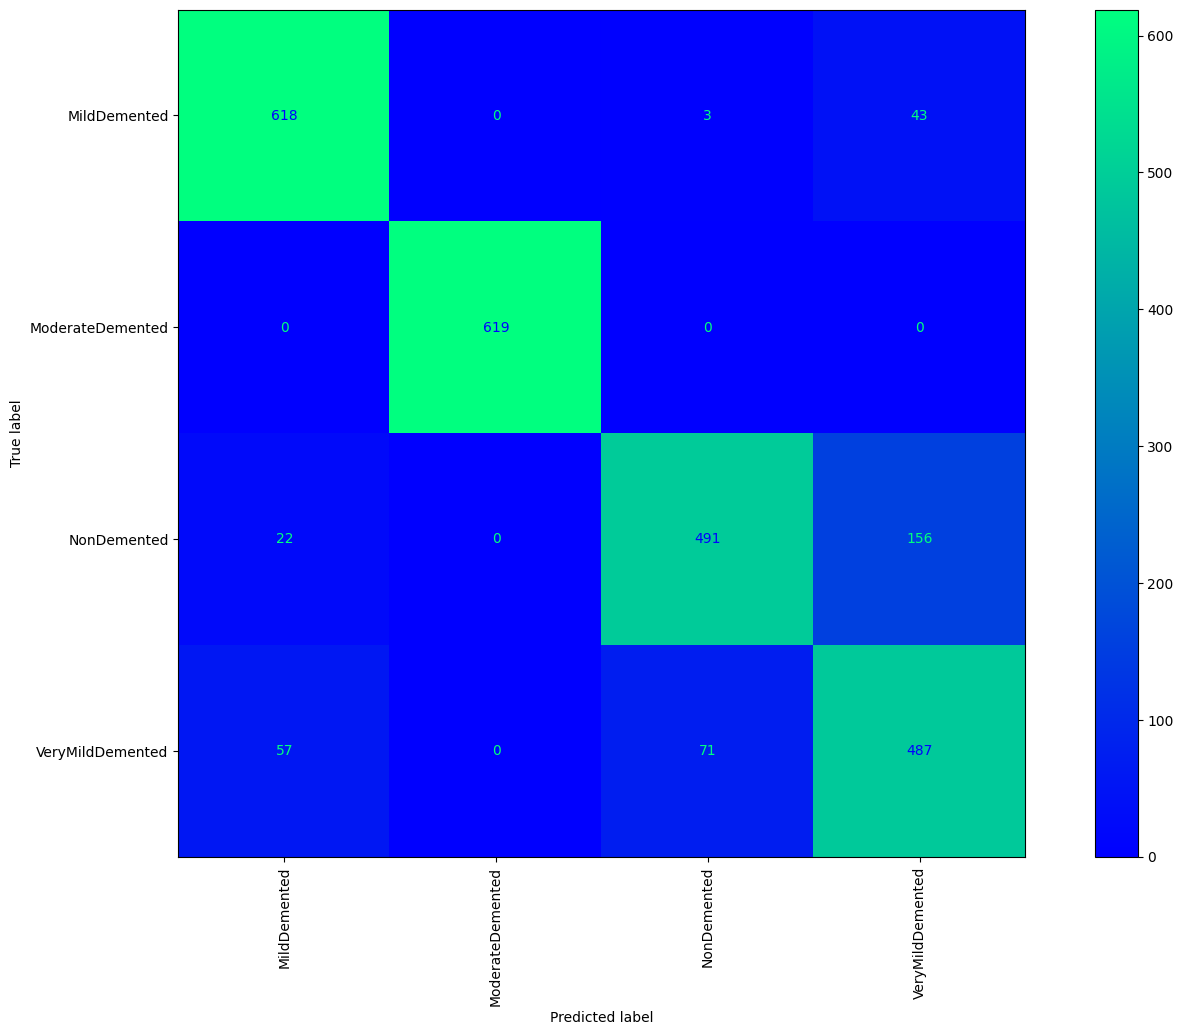

In [ ]:
labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

disp = ConfusionMatrixDisplay(confusion_matrix=conf_arr,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(18, 11))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='winter')

plt.show()

Text(0.5, 1.0, 'Training and Testing Accuracy Curves')

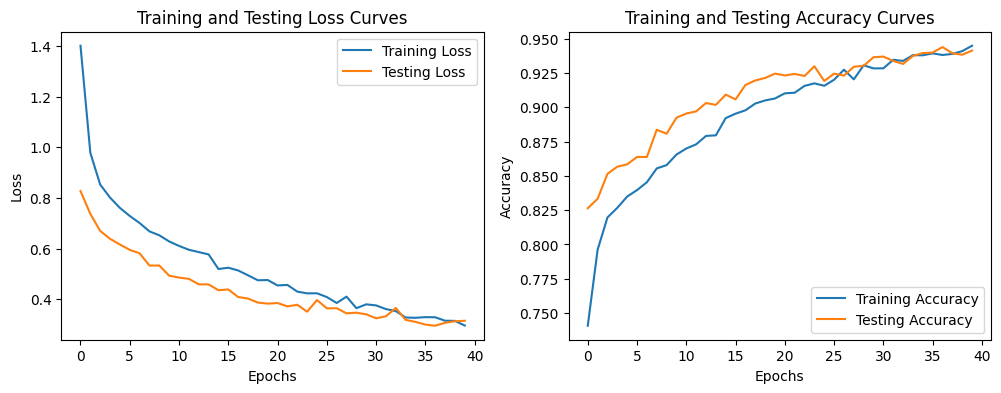

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and testing loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Curves')

# Plot the training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Curves')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
